# Filtered navigable network

This notebook test the way to create nodes and edges compatibles with OSMnx in order to be able to __use Santiago's public space quality index__ (Available in non-OSMnx road linestrings) __as a filter.__

The steps to be followed are the currently working QGIS steps:
1. Split lines with lines
2. Vector > Geometry Tools > Multipart to singleparts
3. Extract specific vertices [0,-1]
4. MMQGIS Modify > Drop dups

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [2]:
gral_dir = '../../../data/external/santiago/'
project_name = 'redvial2019_buffer_3750m_c_utilidad_2'
p_code = '00'
public_space_quality_dir = gral_dir + f"calidad_ep/{p_code}_{project_name}/{project_name}.shp"

# Projection to be used whenever necessary
projected_crs = 'EPSG:32719'
# Column to filter data
filtering_column = 'pje_ep'
filtering_value = 0.5 # Will keep equal or more than this value

## Load data

In [3]:
# 1.0 --------------- LOAD DATA
# ------------------- This step loads the public space quality index gdf for the current project
# Load data
pub_space_qty = gpd.read_file(public_space_quality_dir)
# Set CRS
pub_space_qty = pub_space_qty.set_crs(projected_crs)
# Filter for data of relevance
gdf = pub_space_qty[[filtering_column,'geometry']].copy()
gdf = gdf.to_crs("EPSG:4326")

# Show
print(gdf.shape)
gdf.head(1)

(31534, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


## Part 1 - How to split lines with themselves?

In [68]:
some_lines = gdf.loc[0:10]
#some_lines.reset_index(inplace=True)
#some_lines = some_lines.rename(columns={'index':'original_id'})

# Show
print(some_lines.shape)
some_lines.head(2)

(11, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


<Axes: >

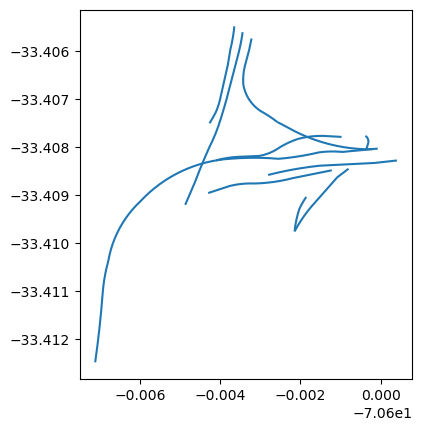

In [139]:
some_lines.plot()

### Split lines with themselves - Intersecting each line with the unary union of the rest of the lines (Working, VERY slow)

In [143]:
from shapely.geometry import GeometryCollection

In [158]:
def split_lines_with_themselves(lines_gdf):
    split_lines = gpd.GeoDataFrame()
    i = 0
    
    # Reset index in order to keep track of original line id
    original_lines = lines_gdf.copy()
    original_lines = original_lines.reset_index()
    original_lines = original_lines.rename(columns={'index':'original_id'})
    
    # Iterate over each line
    for idx in list(original_lines.original_id.unique()):
        # Find original line and its geometry
        line_of_interest = original_lines.loc[original_lines.original_id == idx]
        line_geom = line_of_interest.geometry.unique()[0]
        # Create unary union (geometry) out of the rest of the lines (Avoids trying to intersect with itself)
        rest_of_lines = original_lines.loc[original_lines.original_id != idx]
        gdf_exploded = rest_of_lines.copy().explode()
        unary_union = gdf_exploded.unary_union
    
        # Try splitting the line with the rest of the lines
        try:
            # Split geom with unary union
            split_result = split(line_geom, unary_union)
            # Extract clipped lines
            split_lines_geoms = list(split_result.geoms)
            # Register data
            for split_line_geom in split_lines_geoms:
                split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
                split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
                split_lines.loc[i,'geometry'] = split_line_geom
            
                i +=1
                
        # Except it doesn't need splitting, then just append the line
        except:
            split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
            split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
            split_lines.loc[i,'geometry'] = line_geom
            i +=1
    
    try:
        split_lines.set_crs("EPSG:4326")
    except:
        split_lines.to_crs("EPSG:4326")
    
    return split_lines

In [ ]:
# Tomó más de 1 hr y no terminó con el gdf completo
split_lines = split_lines_with_themselves(gdf)

# Show
print(split_lines.shape)
split_lines.head(2)

In [ ]:
# Check result
#some_lines.to_file(gral_dir + "some_lines.gpkg", driver='GPKG')
#split_lines.to_file(gral_dir + "split_lines.gpkg", driver='GPKG')

In [55]:
sjoined = some_lines.sjoin(some_lines)
test = sjoined.loc[sjoined.original_id_left == 1]
test

,original_id_left,pje_ep_left,geometry,index_right,original_id_right,pje_ep_right
1,1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",1,1,0.273895
1,1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",8,8,0.282520


In [47]:
#fig,ax=plt.subplots(1,2,figsize=(10,20))
#some_lines.plot("original_id",ax=ax[0])
#test.plot("original_id",ax=ax[1])

In [46]:
test.to_file(gral_dir + "test.gpkg", driver='GPKG')

### Split lines with themselves - Sjoin to identify which lines cross with which lines (Not working)

In [94]:
def split_lines_with_themselves(lines_gdf):

    original_lines = lines_gdf.copy()
    original_lines.reset_index(inplace=True)
    original_lines = original_lines.rename(columns={'index':'original_id'})

    idx_lst = [0,1,2,3,4,5,6,7,8] #list(original_lines.original_id.unique())

    # Find which lines intersect with which lines
    sjoined = original_lines.sjoin(original_lines)
    
    split_lines_list = []
    for idx in idx_lst:
        # Locate line of interest
        line_of_interest = original_lines.loc[original_lines.original_id==idx]
        # Locate which lines intersect that line of interest (Drop itself)
        sjoined_line = sjoined.loc[sjoined.original_id_left==idx]
        intersecting_lines_ids = list(sjoined_line.original_id_right.unique())
        intersecting_lines_ids.remove(idx)
        intersecting_lines = original_lines.loc[original_lines.original_id.isin(intersecting_lines_ids)]

        # Geometry of line of interest
        line_to_split = line_of_interest.geometry
        # Iterate over each intersecting lines geometry
        for splitter in intersecting_lines.geometry:
        
    return line_of_interest, intersecting_lines

line_of_interest, intersecting_lines = split_lines_with_themselves(some_lines)

### Split lines with themselves - Stack overflow Help (Not working)

In [27]:
gdf_exploded = gdf.copy().explode()
gdf_exploded.geom_type.unique()

array(['LineString'], dtype=object)

In [34]:
# split ways
gdf_exploded = gdf.copy().explode()
geometries = [i for i in gdf_exploded.geometry]
ids = [j for j in range(len(geometries))]
unary = gpd.GeoDataFrame({"id": ids, "geometry": geometries}, crs="EPSG:4326")
results = [] #empty list to store the results
for i in range(len(unary)):
    joined = gpd.sjoin(unary.loc[[i]], gdf_exploded, how="inner", op='within')
    results.append(joined)
joined = pd.concat(results)

joined

,id,geometry,index_right0,index_right1,pje_ep
0,0,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",0,0,0.209171
1,1,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",1,0,0.273895
2,2,"LINESTRING (-70.60215 -33.40975, -70.60207 -33...",2,0,0.335099
3,3,"LINESTRING (-70.60215 -33.40975, -70.60213 -33...",3,0,0.106013
4,4,"LINESTRING (-70.60426 -33.40751, -70.60418 -33...",4,0,0.019630
...,...,...,...,...,...
31549,31549,"LINESTRING (-70.69190 -33.45897, -70.69192 -33...",31529,0,0.581119
31550,31550,"LINESTRING (-70.65000 -33.48546, -70.64996 -33...",31530,0,0.039703
31551,31551,"LINESTRING (-70.65020 -33.48616, -70.65018 -33...",31531,0,0.012621
31552,31552,"LINESTRING (-70.64985 -33.48548, -70.64968 -33...",31532,0,0.052166


### Split lines with themselves - ChatGPT Help (Not working)

In [113]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import split

In [15]:
def split_lines_with_themselves(lines_gdf):
    # Ensure geometries are valid
    lines_gdf = lines_gdf[lines_gdf.is_valid]

    split_lines_list = []

    for idx, line in lines_gdf.iterrows():
        line_to_split = line.geometry  # Initialize the line to be split
        for splitter in lines_gdf.geometry:
            if line_to_split != splitter:  # Avoid splitting a line with itself
                try:
                    # Perform the split
                    split_result = split(line_to_split, splitter)
                    # Ensure that split_result has elements
                    if split_result:
                        split_line = MultiLineString([geom for geom in split_result])
                        
                        # Append the resulting split lines to the list inside the loop
                        if isinstance(split_line, MultiLineString):
                            split_lines_list.extend(split_line.geoms)  # Use .geoms to iterate over the LineStrings in the MultiLineString
                        else:
                            split_lines_list.append(split_line)
                except:
                    continue
    
    # Create a new GeoDataFrame with the split lines
    split_lines_gdf = gpd.GeoDataFrame(geometry=split_lines_list, crs=lines_gdf.crs)
    
    return split_lines_gdf

# Perform split_lines_with_themselves
#lines_gdf = gdf.copy()
#split_lines_gdf = split_lines_with_themselves(lines_gdf)

# Show
#print(split_lines_gdf.shape)
#split_lines_gdf.head(1)